In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [24]:
#nvidia prices into Data Frame
nvidia = yf.Tickers('NVDA')
nhist = nvidia.history(period='max')

#Take only date, close, vol columns
nhist = nhist.drop(columns=['Stock Splits', 'Dividends', 'High', 'Low', 'Open'])


corr = nhist.corr()

corr

[*********************100%***********************]  1 of 1 completed


,Price,Close,Volume
,Ticker,NVDA,NVDA
Price,Ticker,,
Close,NVDA,1.000000,-0.172117
Volume,NVDA,-0.172117,1.000000


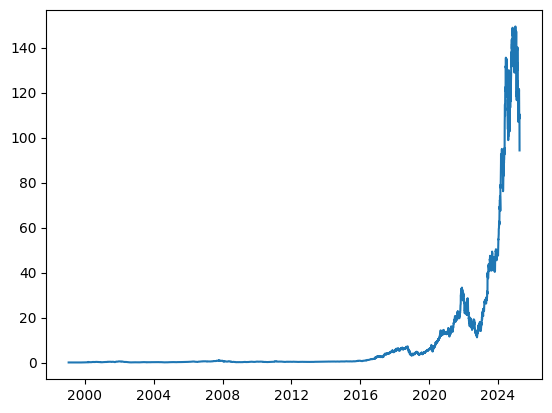

In [22]:
#nvidia price over time
plt.plot(nhist['Close'])
